# TRABALHO 2 - PARTE B

## Implementação de um Classificador Perceptron

In [1]:
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Equipe

**Ícaro de Lima** - 385194

**Thalisson Felipe** - 390195

Neste trabalho utilizamos dois datasets para o estudo do Perceptron, para baixá-los clique [aqui](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results/data?select=athlete_events.csv) e [aqui](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). Após baixá-los, coloque os datasets na pasta datasets.

In [2]:
class Perceptron(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                # target - self.predict(xi) -> error
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

# Questao 1 - Implemente uma função para calcular a acurácia do modelo

In [3]:
def accuracy(y_pred, y_true):
    total = len(y_pred)
    matches = np.sum(y_pred == y_true)
    
    return matches / total

A função para calcular a acurácia é bem simples. Passamos como parâmetro a classe target y predita e a classe target real. A acurácia é calculada então como uma proporção entre o número de predições corretas e o total de valores preditos, isto é, predições que coincidem com o valor real do teste.

# Questao 2 - Implemente um método de validação cruzada para testar 

In [4]:
def train_test_split(train, test):
    features = train[0].columns.tolist()
    target = features.pop()

    X_train = [tr[features].values for tr in train][0]
    y_train = [tr[target].values for tr in train][0]
    X_test = np.array(test[features].values)
    y_test = np.array(test[target].values)

    return (X_train, y_train, X_test, y_test)

def cross_validation(perceptron, dataset, n_folds=10, shuffle=False):
    accs = []

    if shuffle:
        dataset = dataset.reindex(np.random.permutation(dataset.index))

    fold_size =  math.floor(len(dataset) / n_folds)
    folds = []
    i = 0
    while i < len(dataset):
        folds.append(dataset[i:i+fold_size])
        i += fold_size

    folds_aux = folds.copy()
    for i, fold in enumerate(folds):
        test = folds_aux.pop(i)
        train = folds_aux

        X_train, y_train, X_test, y_test = train_test_split(train, test)

        perceptron.fit(X_train, y_train)
        y_pred = perceptron.predict(X_test)
        accs.append(accuracy(y_pred, y_test))

        folds_aux.insert(i, fold)

    return np.mean(accs)

def cross_validation_model(perceptron, dataset, n_folds=10, shuffle=False):
    accs = []
    acc = 0

    if shuffle:
        dataset = dataset.reindex(np.random.permutation(dataset.index))

    fold_size =  math.floor(len(dataset) / n_folds)
    folds = []
    i = 0
    while i < len(dataset):
        folds.append(dataset[i:i+fold_size])
        i += fold_size

    folds_aux = folds.copy()
    for i, fold in enumerate(folds):
        test = folds_aux.pop(i)
        train = folds_aux

        X_train, y_train, X_test, y_test = train_test_split(train, test)

        perceptron.fit(X_train, y_train)
        y_pred = perceptron.predict(X_test)
        accs.append(accuracy(y_pred, y_test))

        if accs[-1] >= acc:
            bestX, bestY = X_train, y_train

        acc = accs[-1]

        folds_aux.insert(i, fold)

    return accs, bestX, bestY

Criamos dois tipos de função para validação cruzada. Primeiramente temos a função que retorna a média das acurácias. A segunda é um pouco mais robusta, ela retorna o fold com a maior acurácia para que possamos, posteriormente, fitar o melhor modelo.

## Teste o classificador usando um conjunto de dados linearmente separável e outro não linearmente separável

Criamos três funções auxiliares: uma para a geração de datasets, uma para visualizar os dados e outra para realizar o treinamento do modelo.

In [5]:
def generate_data(n_samples, linear=False):
    random_x = np.arange(0, 20)
    random_y = [1, -1]

    X, y = [], []
    for _ in range(n_samples):
        X.append([random.choice(random_x), random.choice(random_x)])
        if linear:
            if X[-1][1] >= len(random_x)/2 and X[-1][0] > 0:
                y.append(random_y[1])
            else:
                y.append(random_y[0])
        else:
            y.append(random.choice(random_y))

    return np.array(X), np.array(y)

In [6]:
def plot(X, y):
    reds, blues = [], []
    for x, y in zip(X, y):
        if y == -1:
            reds.append(x)
        else:
            blues.append(x)

    transpose_reds = np.transpose(reds)
    transpose_blues = np.transpose(blues)
    
    fig = plt.figure(figsize=(16, 10))
    plt.scatter(transpose_reds[0], transpose_reds[1], c='red')
    plt.scatter(transpose_blues[0], transpose_blues[1], c='blue')
    plt.xlabel('X1', fontsize=16)
    plt.ylabel('X2', fontsize=16)
    plt.title('Gráfico de dispersão entre duas features fictícias', fontsize=18)
    plt.show()

In [7]:
def evaluate(n_samples, eta, n_iter, linear, showPlot=True):
    X, y = generate_data(n_samples, linear)
    n = len(X)
    limite = math.floor(0.6 * n)
    X_train, y_train = X[0:limite], y[0:limite]
    X_test, y_test = X[limite:n], y[limite:n]

    p = Perceptron(eta=eta, n_iter=n_iter)
    p.fit(X_train, y_train)
    y_pred = p.predict(X_test)
    acc = accuracy(y_pred, y_test)
    
    if showPlot:
        plot(X, y)
    
    return acc

### Conjunto de dados não linearmente separável

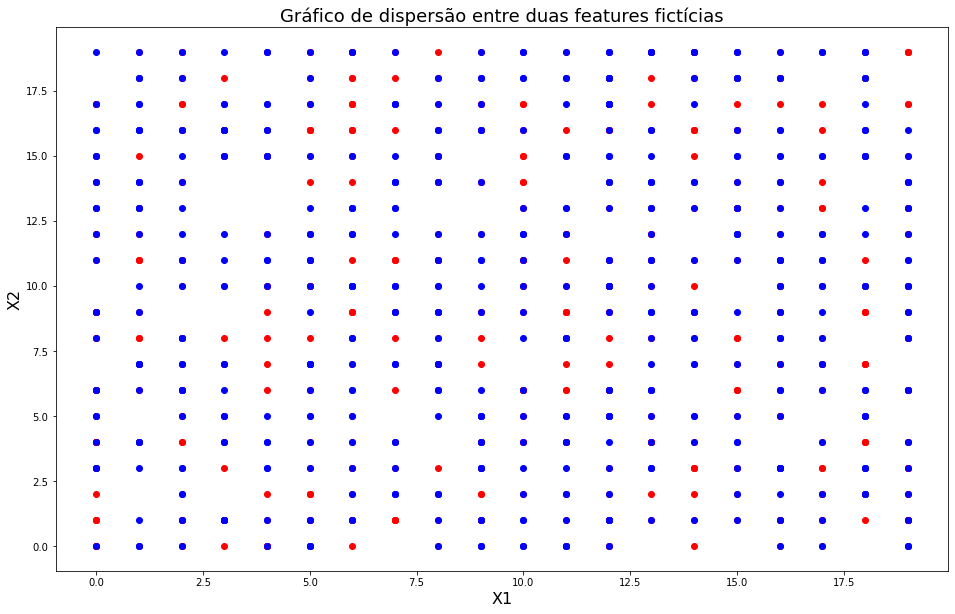

Acurácia: 0.4975


In [8]:
acc = evaluate(n_samples=1000, eta=0.5, n_iter=100, linear=False)
print('Acurácia:', acc)

### Conjunto de dados linearmente separável

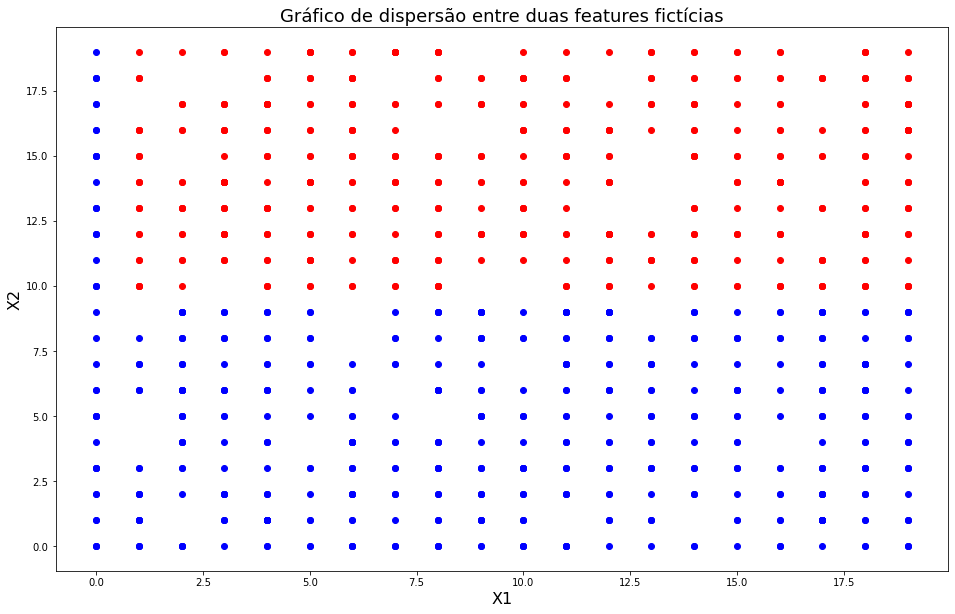

Acurácia: 0.8625


In [9]:
acc = evaluate(n_samples=1000, eta=0.2, n_iter=100, linear=True)
print('Acurácia:', acc)

# Questao 3 - Treine um classificador perceptron para os dados de seu estudo de caso

### Dados:
Primeiramente utilizamos os dados que trabalhamos no estudo de caso anterior. Os dados são registro dos 100 anos das olimpíadas. Este dataset possui 271116 linhas e 15 colunas. Cada linha representa as informação de um evento de um atleta. O ID é usado como identificador único. As informações são desde 1896 em Atenas até 2016 no Rio de Janeiro. 

Atributos:
* **ID** - identificador único do atleta
* **Name** - nome do atleta
* **Sex** - sexo do atleta (M e F)
* **Age** - idade do atleta
* **Height** - altura do atleta em cm
* **Weight** - peso do atleta em kg
* **Team** - país que o atleta representa
* **NOC** - National Olympic Committee
* **Games** - ano e temporada do evento
* **Year** - ano do evento
* **Season** - temporada do evento
* **City** - cidade em que aconteceu o evento
* **Sport** - esporte que o atleta participou
* **Event** - nome do evento
* **Medal** - medalha que o atleta ganhou (NaN, Gold, Bronze e Silver)

### PARTE 01 - Primeiro modelo

### Obtendo o dataset

In [10]:
df = pd.read_csv('datasets/athlete_events.csv')
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


Porém, mesmo que nossa intenção inicial fosse utilizar os mesmos dados, eles não se encaixam muito bem para este tipo classificação. Ainda assim, podemos extrair algum tipo de maneira de classificar, como vamos mostrar mais adiante.
Medalhas, por exemplo, não é algo que seja possível predizer baseado nas features que temos. Claro que o condicionamento físico pode tornar mais provável uma vitória, mas o esporte é algo imprevisível, onde as emoções as vezes fogem da lógica e das probabilidades e geram vitórias ou derrotas inesperadas. Sendo assim, procuramos uma melhor maneira de classificar algum tipo de dado no nosso dataset usando o perceptron.

Nossa ideia então foi fazer uma classificação esportiva, isto é, dado algumas features do atleta (Sexo, Altura, Peso e Idade) determinar se ele seria um praticante apto de um esporte específico (1) ou não (-1). Este tipo de análise é uma tentativa de trabalharmos com os dados do último trabalho, que já temos algum conhecimento, e tentar extrair o máximo disto.


### Pré-processamento

Primeiramente vamos remover todos os dados duplicados e NaN nas colunas que são importantes:

In [11]:
_df = df.drop_duplicates(subset='ID', keep="first") # eliminando duplicatas
_df = _df.dropna(axis=0, subset=['Height', 'Weight', 'Age', 'Sex', 'Team']) # eliminando dados NaN

Agora, precisamos remover as colunas com features que não iremos precisar para o modelo:

In [12]:
df_proc = _df.drop(columns=['ID','Name','Year', 'NOC', 'Games', 'Season', 'City', 'Event', 'Medal', 'Team'])
df_proc.head()

,Sex,Age,Height,Weight,Sport
0,M,24.0,180.0,80.0,Basketball
1,M,23.0,170.0,60.0,Judo
4,F,21.0,185.0,82.0,Speed Skating
10,M,31.0,188.0,75.0,Cross Country Skiing
18,M,31.0,183.0,72.0,Cross Country Skiing


Agora precisamos mudar a representação de alguns dados, já que não podemos lidar com strings, os valores têm que ser numéricos. Então vamos trocar a coluna sports pela coluna target. Dado um esporte específico, no nosso caso escolhemos <b>Basquete</b>, a coluna target será preenchida com 1 se aquele atleta pratica o esporte determinado e -1 se ele pratica outro esporte. Em seguida, trocamos o sexo também por uma representação binária, se for feminino (F) será representado por 1 e se for masculino (M) será representado com 0. Desta maneira, podemos ter apenas valores númericos nas nossas features e na nossa classe target. 

Obs.: Criamos a função normalize_target_and_sex para uso posterior e evitar códigos duplicados.

In [13]:
def normalize_target_and_sex(dataset, target_name):
    df = dataset.copy()
    df['Target'] = (df['Sport'] == target_name).astype(int)
    df['Target'] = df['Target'].replace([0], -1)
    df['Sex'] = (df['Sex'] == 'F').astype(int)
    df = df.drop(columns=['Sport'])
    
    return df

In [14]:
df_sport = normalize_target_and_sex(df_proc, 'Basketball')
df_sport.head()

,Sex,Age,Height,Weight,Target
0,0,24.0,180.0,80.0,1
1,0,23.0,170.0,60.0,-1
4,1,21.0,185.0,82.0,-1
10,0,31.0,188.0,75.0,-1
18,0,31.0,183.0,72.0,-1


In [15]:
def scatterPlot(dataset, target, x, y):
    df1 = dataset.loc[dataset[target] == 1]
    df2 = dataset.loc[dataset[target] == -1]

    fig = plt.figure(figsize=(16, 10))
    plt.scatter(df2[x], df2[y], c='red')
    plt.scatter(df1[x], df1[y], c='blue')
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.title('Gráfico de dispersão: ' + x + ' vs ' + y, fontsize=16)
    plt.show()

def scatterPlot3d(dataset, target, x, y, z):
    df1 = dataset.loc[dataset[target] == 1]
    df2 = dataset.loc[dataset[target] == -1]

    fig = plt.figure(figsize=(16, 10))
    ax = Axes3D(fig)

    ax.scatter(df1[x], df1[y], df1[z], c='blue')
    ax.scatter(df2[x], df2[y], df2[z], c='red')
    ax.set_xlabel(x, fontsize=16)
    ax.set_ylabel(y, fontsize=16)
    ax.set_zlabel(z, fontsize=16)
    plt.title('Gráfico de dispersão: ' + x + ' vs ' + y + ' vs ' + z, fontsize=18)
    plt.show()

Acontece que para o perceptron classificar de maneira adequada, os dados devem ser linearmente separáveis. Para termos uma melhor visualização disso, fizemos um gráfico de dispersão com alguma das features (Altura e Peso) do nosso dataset em relação ao target ou seja, em relação a prática do esporte. No gráfico, temos em azul os atletas que praticam o esporte (Basketball) e em vermelho os que não praticam.

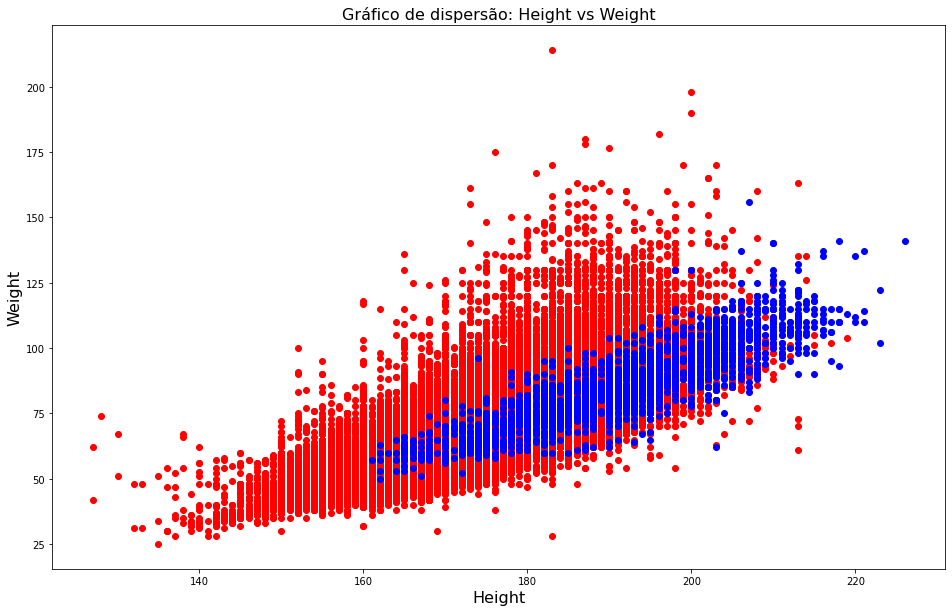

In [16]:
scatterPlot(df_sport, 'Target', 'Height', 'Weight')

Vemos que os dados vistos no gráfico estão bem sobrepostos e não são facilmente separáveis linearmente. Uma alternativa que pensamos foi no gráfico de dispersão usando três features (logo, 3D), assim podemos checar se em três dimensões ele seria separável linearmente (traçando um plano, por exemplo).

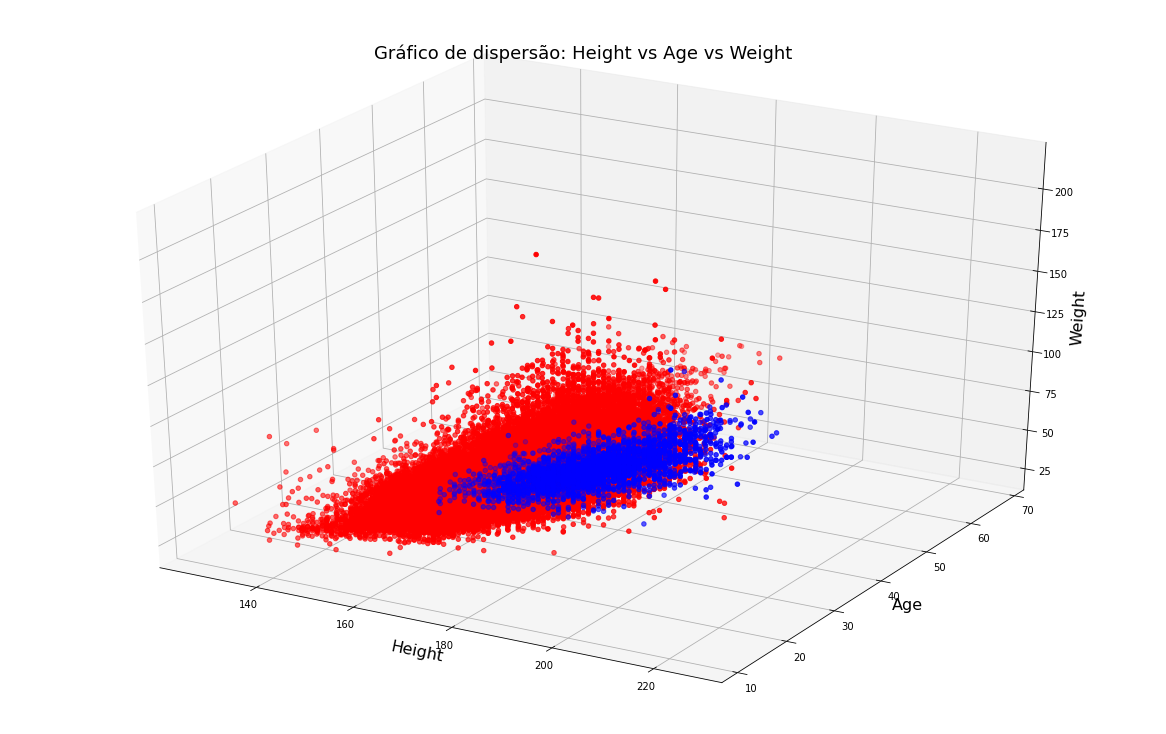

In [17]:
scatterPlot3d(df_sport, 'Target', 'Height', 'Age', 'Weight')

Ainda assim, vemos que os dados continuam muito sobrepostos. Porém vamos seguir com as etapas para classificação com o perceptron. Criamos o perceptron e usamos nossa função de validação cruzada para determinar qual a melhor divisão para os dados em teste e treino.

### Treinamento e Cross validation

In [18]:
ppc = Perceptron(eta=0.5, n_iter=10)
accs, X, y = cross_validation_model(ppc, df_sport, n_folds=10)
print('Acurácia média: ', np.mean(accs))

Acurácia média:  0.9644410393804822


O modelo abaixo é o modelo que teve melhor acurácia na cross validation.

In [19]:
ppc.fit(X, y)

A acurácia é bem alta, mas isto é um problema do modelo e da maneira como os dados se sobrepõe. Como os dados estão muito sobrepostos o modelo simplesmente prediz o valor que é mais frequente, no caso <b>-1</b>. Isto porque no conjunto inteiro de dados, a maior parte dos dados são de quem não pratica um esporte específico, dentre muitos outros. Ora, atletas de uma modalidade como o basquete em comparação a todos os atletas de todas as outras modalidades, é bem desbalançeado. Sendo assim, ele vai predizer como -1 e acerta uma boa quantidade deles, por isso uma acurácia alta. Mais um motivo para um cientista de dados conhecer e entender cada detalhe sobre o dataset e modelo que está trabalhando e a solução que quer desenvolver.

### PARTE 02 - Mudando o subset para um linearmente separável

Como mostrado anteriormente, por mais que a acurácia seja alta, a classificação na verdade não está adequada. Pensamos então em um subset dos nossos dados que fossem linearmente separáveis (ou o mais próximo disso) para que a classificação pudesse ser feita. Ao invés de analisar todos os esportes contra um escolhido, decidimos então tomar apenas dois (Basquete e Ginástica). Assim o classificador decide, baseado nas mesmas features, se é mais provável que determinado atleta seja um atleta de basquete ou de ginástica.

<i> Reiteramos que este tipo de análise é bem limitada e sem grandes aplicações práticas. Ainda assim, insistimos em um tipo de análise que pudesse ser aplicada no nosso dataset, mais por fins de aprendizado.</i>

### Obtendo o dataset

In [20]:
new_df = _df.copy()
new_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
10,6,Per Knut Aaland,M,31.0,188.0,75.0,United States,USA,1992 Winter,1992,Winter,Albertville,Cross Country Skiing,Cross Country Skiing Men's 10 kilometres,NaN
18,7,John Aalberg,M,31.0,183.0,72.0,United States,USA,1992 Winter,1992,Winter,Albertville,Cross Country Skiing,Cross Country Skiing Men's 10 kilometres,NaN


O processo, como até mesmo ilustrado no nosso fluxograma na parte A, é bem parecido com o que fizemos anteriormente. Contudo, vamos filtrar os dados para manter apenas atletas de basquete e de ginástica. Além de remover NaN e as colunas que não interessam.

### Pré-processamento

In [21]:
new_df = new_df.loc[new_df['Year'] >= 1900]
new_df_sport =  new_df.loc[(new_df['Sport'] == 'Gymnastics') | (new_df['Sport'] == 'Basketball')]
new_df_sport = new_df_sport.drop(columns=['ID', 'Name', 'Year', 'NOC', 'Games', 'Season', 'City', 'Event', 'Medal', 'Team'])
new_df_sport.head()

,Sex,Age,Height,Weight,Sport
0,M,24.0,180.0,80.0,Basketball
41,M,28.0,175.0,64.0,Gymnastics
139,M,23.0,167.0,64.0,Gymnastics
167,F,19.0,185.0,72.0,Basketball
264,M,29.0,195.0,85.0,Basketball


In [22]:
print('Tamanho dos dados filtrados para ambos os esportes:', len(new_df_sport))
print('Tamanho dos dados filtrados para apenas basquete:', len(new_df_sport.loc[new_df_sport['Sport'] == 'Basketball']))

Tamanho dos dados filtrados para ambos os esportes: 4793
Tamanho dos dados filtrados para apenas basquete: 2637


Para evitar o mesmo problema que aconteceu anteriormente, na parte 01, checamos a proporção entre os dados. Vemos que a proporção é bem parecida. Sendo 2637 amostras relacionadas ao Basquete e 2156 relacionadas a Ginástica.

In [23]:
new_df_target = normalize_target_and_sex(new_df_sport, 'Basketball')
new_df_target.head()

,Sex,Age,Height,Weight,Target
0,0,24.0,180.0,80.0,1
41,0,28.0,175.0,64.0,-1
139,0,23.0,167.0,64.0,-1
167,1,19.0,185.0,72.0,1
264,0,29.0,195.0,85.0,1


Como no procedimento anterior, adicionamos o Target e trocamos os dados do Sexo para valores numéricos

Agora vamos criar os gráficos de dispersão 2D e 3D dos dados para vermos se eles são linearmente separáveis ou não.

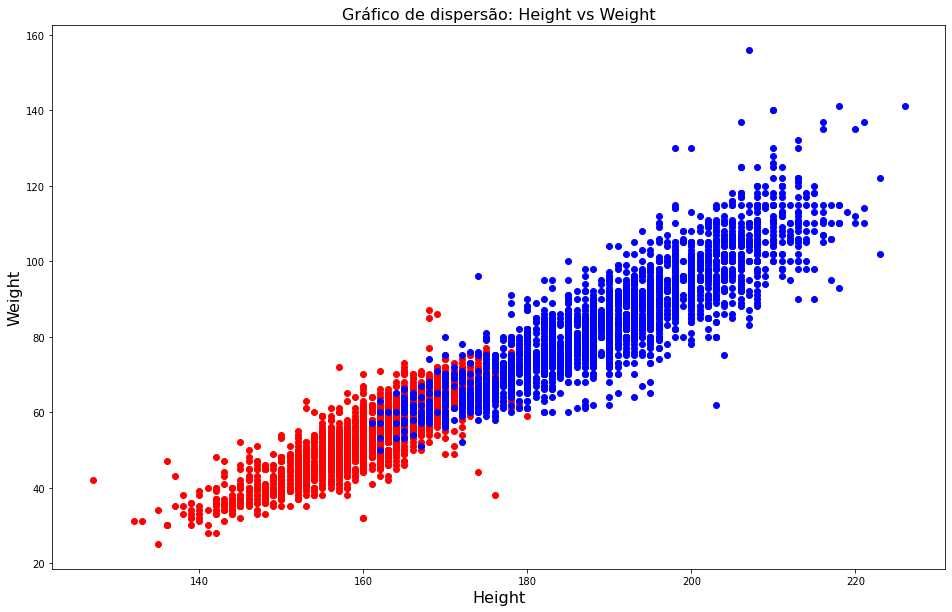

In [24]:
scatterPlot(new_df_target, 'Target', 'Height', 'Weight')

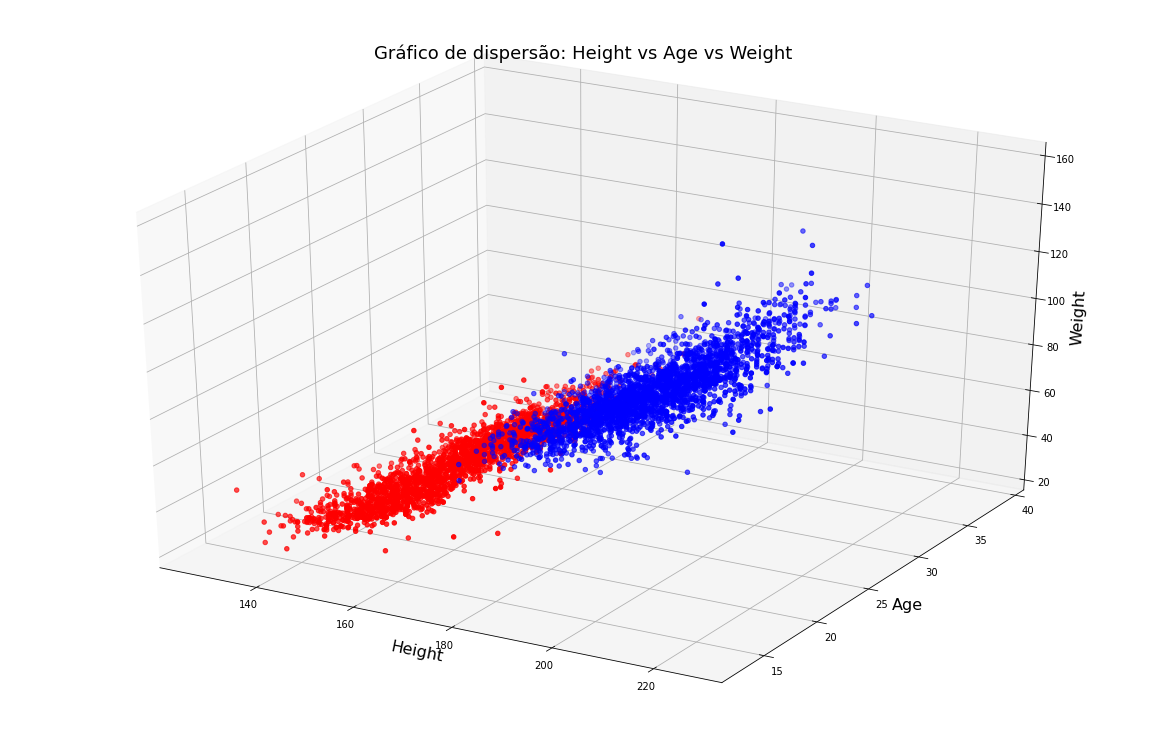

In [25]:
scatterPlot3d(new_df_target, 'Target', 'Height', 'Age', 'Weight')

Usando duas features já vemos que ele é bem mais separável do que os dados que trabalhamos na parte 01, apenas com uma pequena faixa de interseção. No gráfico 3D também vemos que as classes continuam mais distinguíveis, mesmo usando três features.

### Treinamento e Cross validation

In [26]:
ppcl = Perceptron(eta=0.2, n_iter=100)
accs, X, y = cross_validation_model(ppcl, new_df_target, n_folds=10, shuffle=False)
print('Acurácia média: ', np.mean(accs))

Acurácia média:  0.819889922186373


In [27]:
ppcl.fit(X, y)

### PARTE 03 - Utilizando o perceptron para saber se um paciente tem câncer de mama benigno ou maligno

Como dito anteriormente, o dataset utilizado no exemplo anterior talvez não fosse nossa melhor escolha por não ser linearmente seprável. Dito isto, após as análises e discussões do dataset anterior, decidimos escolher um dataset linearmente separável para termos noção do quão bom o Perceptron é com esse tipo de dado. Além disso, com a escolha deste conjunto de dados, temos uma melhor análise de um problema real e que a predição pode ser muito importante e de grande ajuda.

Esse dataset possui 569 linhas e 32 features. Os dados foram obtidos a partir de uma imagem digitalizada de uma aspiração por agulha fina (FNA - Fine Needle Aspiration) de uma massa mamária e descreve as características de suas células núcleos.
O processo é parecido com o visto nas partes 01 e 02.

### Obtendo o dataset

In [28]:
dataset = pd.read_csv('datasets/data.csv')
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### Pré-processamento

Recuperaramos somente as features de interesse. Nesse caso vamos ignorar as colunas 'id', 'unnammed: 32'. E também removemos a coluna 'diagnosis', pois ela é o nosso target.

In [29]:
data = dataset[dataset.columns.tolist()[2:len(dataset.columns.tolist())-1]]
data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Checando se o dataset possui valores nulos.

In [30]:
data.isnull().values.any()

False

Montar o nosso vetor de targets. Os valores de target são B (Benigno) e M (Maligno). Como o perceptron não entende string, normalizamos nosso target e representamos como números. Representamos M como -1 e B como 1.

In [31]:
target = dataset['diagnosis'].replace(['M', 'B'], [-1, 1])

### Treinamento

Criamos uma função para separar o dataset em datasets de treino e de teste para posterior validação.

In [32]:
def split_dataset(dataset, target, shuffle=True):
    n = len(dataset)
    limit = math.floor(0.6 * n)
    
    if shuffle:
        dataset = dataset.reindex(np.random.permutation(dataset.index))
    
    X_train, y_train = dataset[0:limit].values, target[0:limit].values
    X_test, y_test = dataset[limit:n].values, target[limit:n].values
    
    return X_train, y_train, X_test, y_test

In [33]:
X_train, y_train, X_test, y_test = split_dataset(data, target, shuffle=False)

Depois de extrairmos todos os dados necessários, treinamos o nosso modelo e calculamos a acurácia. Podemos ver abaixo que a acurácia foi muito boa porque os dados são linearmente separáveis.

In [34]:
p = Perceptron(eta=0.1, n_iter=100)
p.fit(X_train, y_train)
y_pred = p.predict(X_test)
acc = accuracy(y_pred, y_test)
print('Acurácia:', acc)

Acurácia: 0.9254385964912281


### Cross-validation

In [35]:
merged = data.copy()
merged.loc[:, 'diagnosis'] = target
merged.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,-1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,-1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,-1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,-1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,-1


In [36]:
p = Perceptron(eta=0.2, n_iter=100)
accs, X, y = cross_validation_model(p, merged, n_folds=10, shuffle=False)
print('Acurácia média:', np.mean(accs))

Acurácia média: 0.8746392496392498


In [37]:
accs

[0.875,
 0.9285714285714286,
 0.875,
 0.8571428571428571,
 0.9464285714285714,
 0.9107142857142857,
 0.8571428571428571,
 0.8392857142857143,
 0.7857142857142857,
 0.8571428571428571,
 0.8888888888888888]

Utilizamos também a cross validação para testar o modelo com diferentes folds. Podemos ver que o resultado da acurácia média também foi boa, porém foi maior utilizando sem a cross validação. Mas podemos ver que dados os valores de acurácia acima, houve um fold com acurácia igual a 0.95 que ultrapassou o valor de 0.93 calculado acima.

## Conclusão

Neste trabalho, até por fins de didática, tentamos utilizar nosso dataset do trabalho passado para classificação usando perceptron. Mesmo sabendo que ele não era um conjunto de dados linearmente separável (Parte 01), tentamos melhorar e analisar subsets específicos dele (Parte 02) e até tivemos bons resultados com isso. Na parte 03, usamos o perceptron para classificar um dataset de diagnóstico de câncer de mama, que é um problema real e muito sério e onde a predição pode ajudar dando um diagnóstico rápido. O bom dessa repetição entre as 3 partes que fizemos é porque nos ajudou a ver como o processo geral é parecido, mas é de suma importância o conhecimento dos dados e uma análise minuciosa de cada detalhe. Isto é fundamental para evitar confusões e problemas com seu modelo de classificação.
Com isso, encerramos nosso trabalho. 
#### Obrigado!